# 이미지 분류를 위한 심층 신경망

심층 신경망을 만드는 저번 과제에서 사용했던 기능을 이번에도 사용할겁니다. 그리고 고양이와 고양이가 아닌 사진으로 분류하는 작업까지 해볼겁니다. 이전 로지스틱 회귀보다 나은 정확도가 나오길 기대해봅시다.


**공부할 내용:**
- 지도학습하는 심층 신경망 구축

## 1 - Packages

- [numpy](https://www.numpy.org/) 텐서간의 연산에 필요한 패키지
- [matplotlib](http://matplotlib.org) 시각화에 필요한 패키지
- [h5py](http://www.h5py.org) h5 파일을 사용하기 위한 패키지
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) 모델을 개인 데이터에 적용해 보기 위한 패키지

**제공되는 패키지**  
- dnn_app_utils: 이전 과제에서 만들었던 기능을 담고있습니다.

- np.random.seed(1) 랜덤하게 생성되는 것들을 고정시켜 정답을 확인할 수 있도록 하는 것

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - 데이터 셋

2번째 과제에서 사용했던 데이터셋을 그대로 사용할겁니다. "Cat vs non-Cat"  
2번째 과제에서 만든 모델의 테스트 데이터 정확도가 70% 였는데 이번에는 더 높은 정확도가 나오길 기대합니다.!!  

**문제**: 주어진 데이터셋("data.h5")의 내용:
    - 학습데이터인 이미지들은 고양이면 1 고양이가 아니면 0 으로 라벨링이 되어있습니다.
    - 검정데이터의 이미지들은 고양이와 고양이가 아닌 사진으로 구성되어있습니다.
    - 각 이미지들의 사이즈는 (num_px, num_px, 3) 으로 색상 채널이 3입니다.

데이터셋에 익숙해지도록 호출해보고 확인해봅시다.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
print(train_x_orig.shape)
print(train_y.shape)
print(test_x_orig.shape)
print(test_y.shape)
# feature_date.shape == (mx, m)
print(train_y[0, 5])  # 0
print(classes[train_y[0,5]].decode("utf-8")) # non-cat = 0, cat = 1
print(classes)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
0
non-cat
[b'non-cat' b'cat']


다음 코드는 데이터셋에서 이미지를 확인하는 코드입니다. 마음 편하게 index를 수정해서 사진들을 확인해보세요~~

y = 0. It's a non-cat picture.


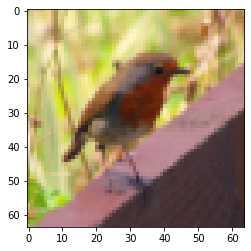

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

#try_n = train_x_orig/255.
#plt.imshow(try_n[index])

In [5]:
print(train_x_orig.shape[0])
print(train_x_orig.shape[1])

209
64


In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px  = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


아래 코드와 같이 일반적으로 모델에 이미지를 입력하기 전에 이미지의 사이즈 변화와 픽셀값들에 일반화를 수행합니다

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ == $64 \times 64 \times 3$  
$12,228$ 은 하나의 이미지를 벡터화 시킨 결과입니다!!

## 3 - 모델의 구조

데이터셋에 익숙해졌다고 가정하고 이제는 고양이와 고양이가 아닌 사진을 구별하는 심층신경망을 구축할 차례입니다.

두 가지 다른 모델을 구축할예정입니다:
- 2 층 짜리 신경망
- L 층 짜리 심층 신경망

이 두 모델의 성능을 비교하고 $L$에 다양한 시도를 해볼겁니다.


### 3.1 - 2층 짜리 신경망

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> 이 모델은 다음과 같이 간단하게 표현할 수 있습니다.: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- 사이즈가 (64, 64, 3)에서 (12288, 1)로 납작하게 벡터화 된 이미지를 입력 데이터로 받습니다.
- 가중치 행렬에서  $W^{[1]}$ 는  $(n^{[1]}, 12288)$ 구조를 갖고 나중에 벡터 $[x_0,x_1,...,x_{12287}]^T$와 곱하게 됩니다.
- 곱한 값에 편향값을 더하고 활성함수 ReLU를 적용하면 다음과 같은 벡터를 얻습니다.  $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- 이 과정을 한번 더 반복합니다.
- 결과 값에 두번째 가중치 행렬을 곱하고 두번째 편향값을 더 합니다,
- 최종적으로 활성함수 sigmoid를 적용해 0.5보다 크면 고양이로 분류하도록 합니다.

### 3.2 - L층 심층 신경망

위에서 했던 작업과 조금 더 복잡하고 다르게 진행합니다.

간단하게 작업과정을 표현해보겠습니다.:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- 사이즈가 (64, 64, 3)에서 (12288, 1)로 납작하게 벡터화 된 이미지를 입력 데이터로 받습니다.
- 가중치 행렬에서  $W^{[1]}$ 는  $(n^{[1]}, 12288)$ 구조를 갖고 나중에 벡터 $[x_0,x_1,...,x_{12287}]^T$와 곱하게 됩니다. 결과값을 선형 유닛으로 표현했습니다.
- 선형 유닛에 활성함수 ReLu를 적용합니다. 이 작업은 모델의 층 수에 따라 반복횟수가 바뀝니다. 
- 최종적으로 활성함수 sigmoid를 적용해 0.5보다 크면 고양이로 분류하도록 합니다.

### 3.3 - 방법론

딥러닝 모델 만드는 방법론:
    1. 매개변수 초기화 / 하이퍼파라미터 선언
    2. 반복:
        a. 순전파
        b. 비용함수 계산
        c. 역전파
        d. 업데이트 매개변수 (역전파로 나온 변화량과 기존의 매개변수 값을 사용) 
    4. 학습된 파라미터를 사용해 최종적으로 모델 생성후 테스트

두 개 모델 구현해봅시다

## 4 - 2층 신경망

**질문**:  이전 과제에서 사용했던 helper function을 사용합니다. *LINEAR -> RELU -> LINEAR -> SIGMOID*.
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [10]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation="relu")
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation="sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

매개변수를 학습하기 위해 아래 셀을 실행하세요.  
모델이 올바르게 작동한다면 비용함수의 값은 줄어들겁니다.  
2500 반복을 수행하는데 5분정도 소요될 수 있습니다. 만약 "Cost after iteration 0"가 예상 출력값과 같지 않다면 노트북 상단에 (⬛) 버튼을 눌러 코드 실행을 중단시키고 잘못 입력한것이 있나 확인해보세요

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196263
Cost after iteration 1200: 0.27491377282130197
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.17448318112556663
Cost after iteration 1600: 0.17080762978096237
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937147
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.06630748

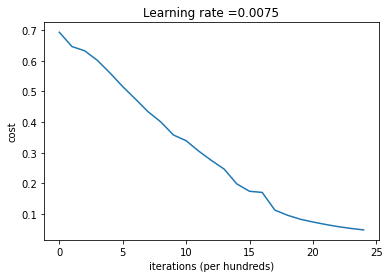

In [13]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770226 </td>
    </tr>
</table>

만약 벡터화하지 않은 입력값을 학습시킨다면 10배 이상의 시간이 걸릴겁니다.  

이제 학습된 매개변수를 갖고 분류를 할수 있게됐습니다. 예측 결과를 확인하기 위해 아래 셀을 실행시켜봅시다.

In [14]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [15]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Note**: 일정 반복만으로도 높은 정확도를 도출하는 것을 확인할 수 있습니다. 이러한 것을 "early stopping" 이라고 합니다. 그리고 이것은 과적합을 방지하는데 사용합니다. (다음 과정에서 다룰 예정입니다.)

지난 과제의 성능(70%) 보다 높은 성능을 도출했습니다. $L$층 모델을 사용하면 어떻게 될지 확인해봅시다.

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [16]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [17]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)

    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

현재 4층 짜리 신경망을 학습시키는 겁니다.

매개변수를 학습하기 위해 아래 셀을 실행하세요.  
모델이 올바르게 작동한다면 비용함수의 값은 줄어들겁니다.  
2500 반복을 수행하는데 5분정도 소요될 수 있습니다. 만약 "Cost after iteration 0"가 예상 출력값과 같지 않다면 노트북 상단에 (⬛) 버튼을 눌러 코드 실행을 중단시키고 잘못 입력한것이 있나 확인해보세요

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


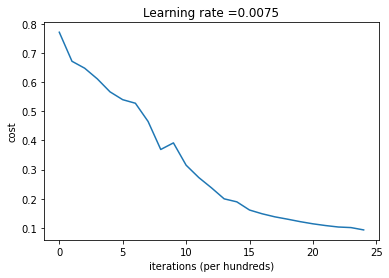

In [18]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [21]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

확실히 4층 신경망이 80%로 상대적으로 좋은 성능을 보이네요.
다음 코스 "심층 신경망 개선 방법" 에서 정확도를 더욱 높이는 방법과 하이퍼파라미터를 선택하는 방법에 대해 공부할 겁니다.

##  6) 결과 분석

첫번째로 L층 신경망에 이미지를 입력해 봅시다. 일부분 잘못된 라벨링 결과가 나올겁니다.

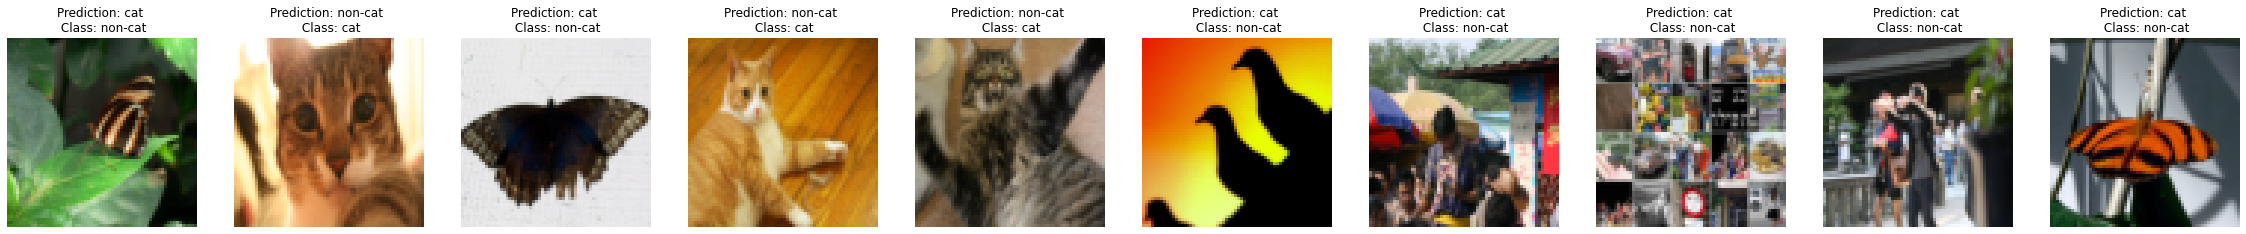

In [23]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**잘못 인식한 사진의 특징들:**
- 고양이 몸의 위치가 일반적이지 않을때
- 고양이의 색과 배경 색이 비슷할때
- 독특한 색의 고양이와 흔하지 않은 고양이 종
- 일반적이지 않은 앵글
- 밝기
- 너무 확대된 고양이 사진 또는 너무 축소된 고양이 사진
- ... 등등

## 7) 개인적인 사진으로 테스트 (optional/ungraded exercise) ##

직접 이미지를 선택해 테스트 해보세요 
직접 테스트 하는 방법:
    1.  위 메뉴 부분에서 File을 선택하고 Open을 누릅니다
    2. "images" 폴더에 사진을 추가합니다
    3. 다음 코드에 업로드한 이미지 이름을 입력합니다.
    4. 이제 코드를 실행해 결과를 확인해보세요

Accuracy: 0.0
y = 1.0, your L-layer model predicts a "cat" picture.


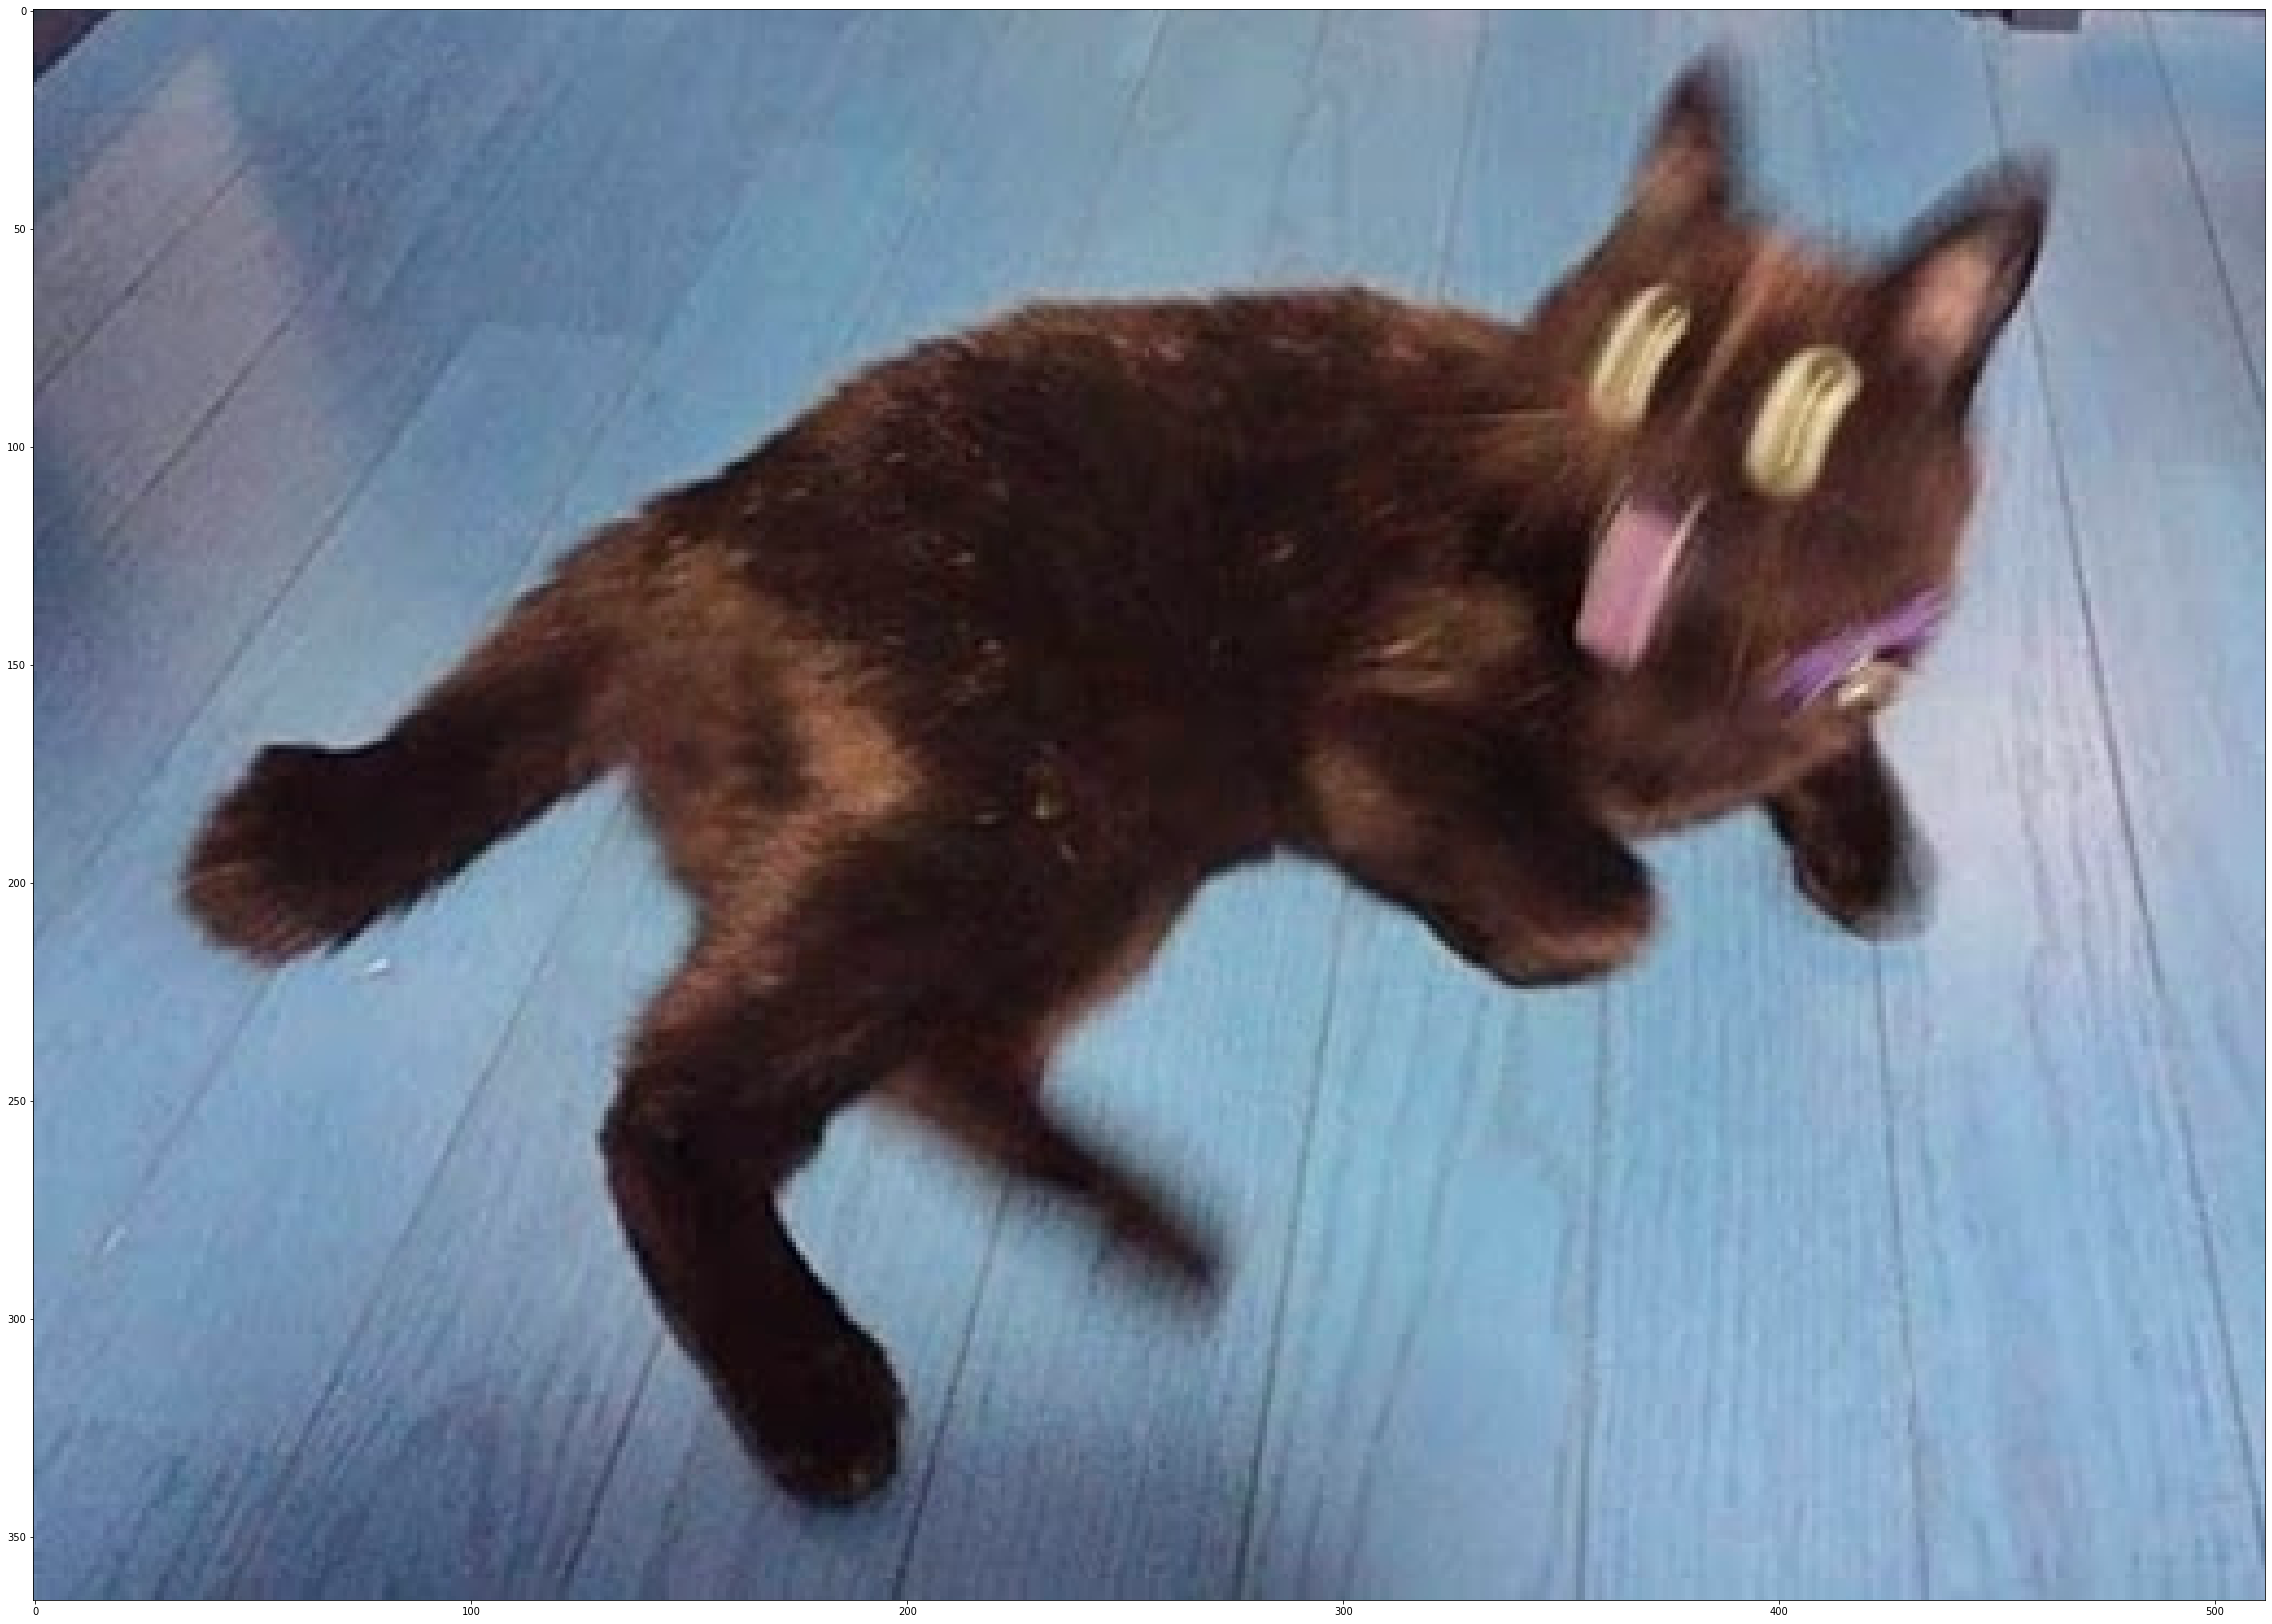

In [35]:
import cv2
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)


fname = "images/" + my_image
image = cv2.imread(fname)
my_image = cv2.resize(image, (num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython